In [1]:
from collections import Counter
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import spacy

import matplotlib
from matplotlib import font_manager
fpath = "/usr/share/fonts/opentype/ipaexfont-gothic/ipaexg.ttf"
font_manager.fontManager.addfont(fpath)
matplotlib.rc('font', family="IPAexGothic")
matplotlib.rcParams['font.family']

['IPAexGothic']

In [2]:
data_path = "./output.json"

In [3]:
nlp = spacy.load("ja_core_news_md")
def tokenize(s: str) -> list[str]:
    doc = nlp(s.lower())
    return [tok.lemma_ for tok in doc if tok.pos_ in ["NOUN"]]

data = pd.read_json(data_path, orient="records", lines=True)
docs = data["title"].apply(tokenize)
docs.head(3)

0                  [競馬, 予想, AI, 爆安]
1      [コード, 改修, カスタマイズ, 小, 規模, 開発]
2    [c, #, vb, NET, プログラム, 作成, 改修]
Name: title, dtype: object

In [4]:
Ndocs = len(docs)
Ndocs

1520

In [5]:
words = docs.explode().value_counts()
Nwords = len(words)
Nwords

1187

In [6]:
lower_threshod = 10
lower_ok = words >= lower_threshod

length_threshold = 2
length_ok = words.index.map(len) >= length_threshold

stop_words = ["title", "unknown"]
stop_ok = words.index.map(lambda s: not s in stop_words)

ok = lower_ok & length_ok & stop_ok
accepted_words = words[ok].index.tolist()

In [7]:
filtered_docs = docs.map(lambda doc: [t for t in doc if t in accepted_words])
filtered_docs = filtered_docs[filtered_docs.map(lambda a: len(a) > 1)]
filtered_docs = filtered_docs.reset_index(drop=True)
print(f"""
{filtered_docs.head(3) = }
{len(filtered_docs) = }
""")


filtered_docs.head(3) = 0      [コード, 改修, 開発]
1    [プログラム, 作成, 改修]
2           [開発, 相談]
Name: title, dtype: object
len(filtered_docs) = 930



In [8]:
G = nx.Graph()
node_weights = Counter()
for doc in filtered_docs:
    for w in set(doc):
        node_weights[w] += 1

    for w1, w2 in combinations(set(doc), 2):  # 組み合わせ（重複排除）
        if G.has_edge(w1, w2):
            G[w1][w2]['weight'] += 1
        else:
            G.add_edge(w1, w2, weight=1)

nx.set_node_attributes(G, node_weights, 'weight')

In [9]:
edge_threshold = 3
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] < edge_threshold]
G.remove_edges_from(edges_to_remove)

In [10]:
comp = list(nx.community.girvan_newman(G))
first_level_communities = comp[0]

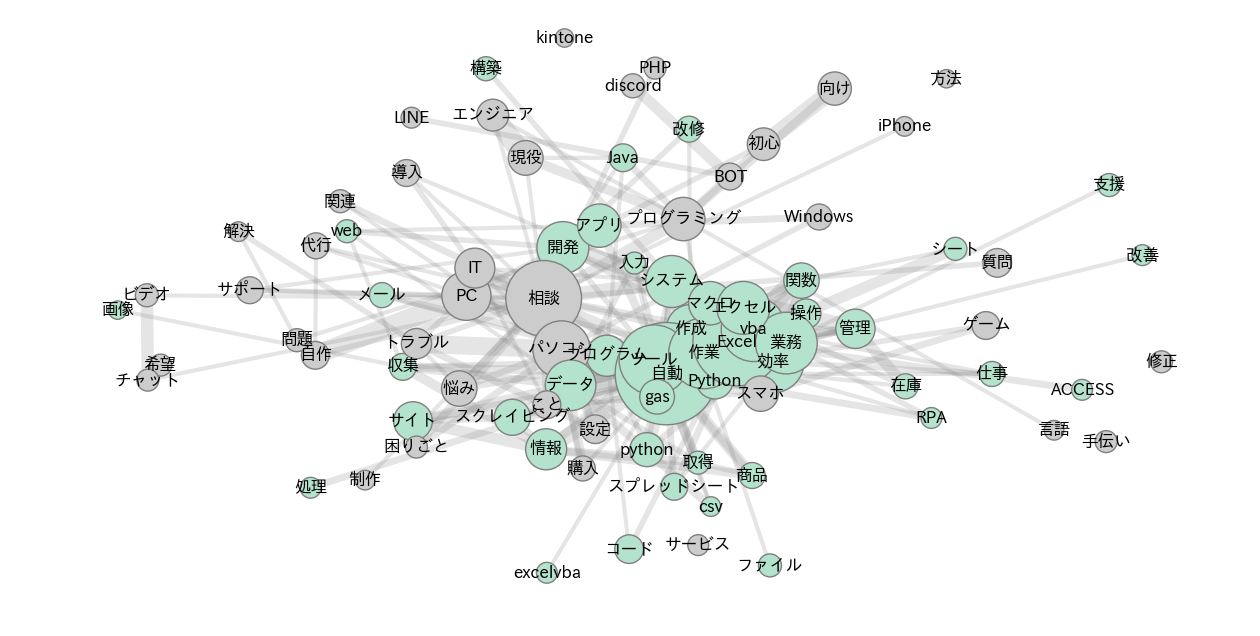

In [11]:
plt.figure(figsize=(16, 8))
pos = nx.spring_layout(G, weight="weight", k=1)
node_sizes = [G.nodes[node].get("weight", 1) * 25 for node in G.nodes()]
edge_weights = [G.edges[edge].get("weight") for edge in G.edges()]
node_colors = [0 if node in first_level_communities[0] else 1 for node in G.nodes()]

nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes,
    cmap=plt.cm.Pastel2,
    node_color=node_colors, edgecolors="gray"
)
nx.draw_networkx_labels(
    G, pos, font_family="IPAexGothic"
)
nx.draw_networkx_edges(
    G, pos, width=edge_weights, 
    edge_color="gray", alpha=0.2
)

plt.axis("off")
plt.show()